# Group Project: Determining Diamond Cut Grades Using KNN Classification

**Section 009 Group 2**

**Ziqing Wang**<br>**Anna Tao**<br>**Ruby de Lang**

### 1. Introduction

The 4Cs: cut, clarity, color, and carat weight, are internationally accepted standards for assessing the quality of a diamond.  Diamond cut grade is a pivotal factor in determining the beauty and value of a diamond.

The dataset being used reports on the characteristics of diamonds. 
We want to use the KNN classification method to predict the cut grades of diamonds.

The columns of the dataset:
* **carat**: a unit of measurement for a diamond's weight.
* **cut**: cut grades of diamonds, measured in five scales (high to low): Ideal, Premium, Very good, Good, Fair.
* **color**: color is graded on a scale from D (colorless) to Z (light yellow or brown).
* **clarity**: the presence of internal and external flaws within a diamond.
* **depth**: the distance from the table to the culet (the bottom of the diamond).
* **table**: the flat, topmost facet of diamonds.
* **price**: The price of diamonds.
* **x**: the x-dimension of diamonds.
* **y**: the y-dimension of diamonds.
* **z**: the z-dimension of diamonds.

### 2. Preliminary exploratory data analysis

In [1]:
# install.packages("tidyverse")
# install.packages("cowplot")
# install.packages("tidymodels")
# install.packages("kknn")
library(tidyverse)
library(ggplot2)
library(repr)
library(tidymodels)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.4     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

**Reading Data from Online Source Into R**

After reading the data, we have 53940 recorded observations.

In [2]:
set.seed(2023)

diamond_data <- read_csv("https://raw.githubusercontent.com/rubydelang/sonar_data/main/diamonds.csv") |>
mutate(cut = as_factor(cut))

#head(diamond_data)
diamond_data

diamond_split <- initial_split(diamond_data, prop = 0.75, strata = cut)
diamond_training <- training(diamond_split)
diamond_testing <- testing(diamond_split)

Rows: 53940 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): cut, color, clarity
dbl (7): carat, depth, table, price, x, y, z

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


carat,cut,color,clarity,depth,table,price,x,y,z
<dbl>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.23,Ideal,E,SI2,61.5,55,326,3.95,3.98,2.43
0.21,Premium,E,SI1,59.8,61,326,3.89,3.84,2.31
0.23,Good,E,VS1,56.9,65,327,4.05,4.07,2.31
0.29,Premium,I,VS2,62.4,58,334,4.20,4.23,2.63
0.31,Good,J,SI2,63.3,58,335,4.34,4.35,2.75
0.24,Very Good,J,VVS2,62.8,57,336,3.94,3.96,2.48
0.24,Very Good,I,VVS1,62.3,57,336,3.95,3.98,2.47
0.26,Very Good,H,SI1,61.9,55,337,4.07,4.11,2.53
0.22,Fair,E,VS2,65.1,61,337,3.87,3.78,2.49


**Tidy Data**

Now looking at the dataset, each row is a single observation, each column is a single variable, with meaningful column names, and each cell contains only a single value. 
Therefore, the data is already tidy so we do not need take any further actions. <br><br>

**Checking for Missing Data** 

The 'na_rows' counts for the number of rows containing missing data, and the result of 0 means we do not have any missing data in this dataset.

In [3]:
na_rows <- sum(apply(is.na(diamond_data), 1, any))
print(na_rows)
summary(diamond_data)

[1] 0


     carat               cut           color             clarity         
 Min.   :0.2000   Ideal    :21551   Length:53940       Length:53940      
 1st Qu.:0.4000   Premium  :13791   Class :character   Class :character  
 Median :0.7000   Good     : 4906   Mode  :character   Mode  :character  
 Mean   :0.7979   Very Good:12082                                        
 3rd Qu.:1.0400   Fair     : 1610                                        
 Max.   :5.0100                                                          
     depth           table           price             x         
 Min.   :43.00   Min.   :43.00   Min.   :  326   Min.   : 0.000  
 1st Qu.:61.00   1st Qu.:56.00   1st Qu.:  950   1st Qu.: 4.710  
 Median :61.80   Median :57.00   Median : 2401   Median : 5.700  
 Mean   :61.75   Mean   :57.46   Mean   : 3933   Mean   : 5.731  
 3rd Qu.:62.50   3rd Qu.:59.00   3rd Qu.: 5324   3rd Qu.: 6.540  
 Max.   :79.00   Max.   :95.00   Max.   :18823   Max.   :10.740  
       y            

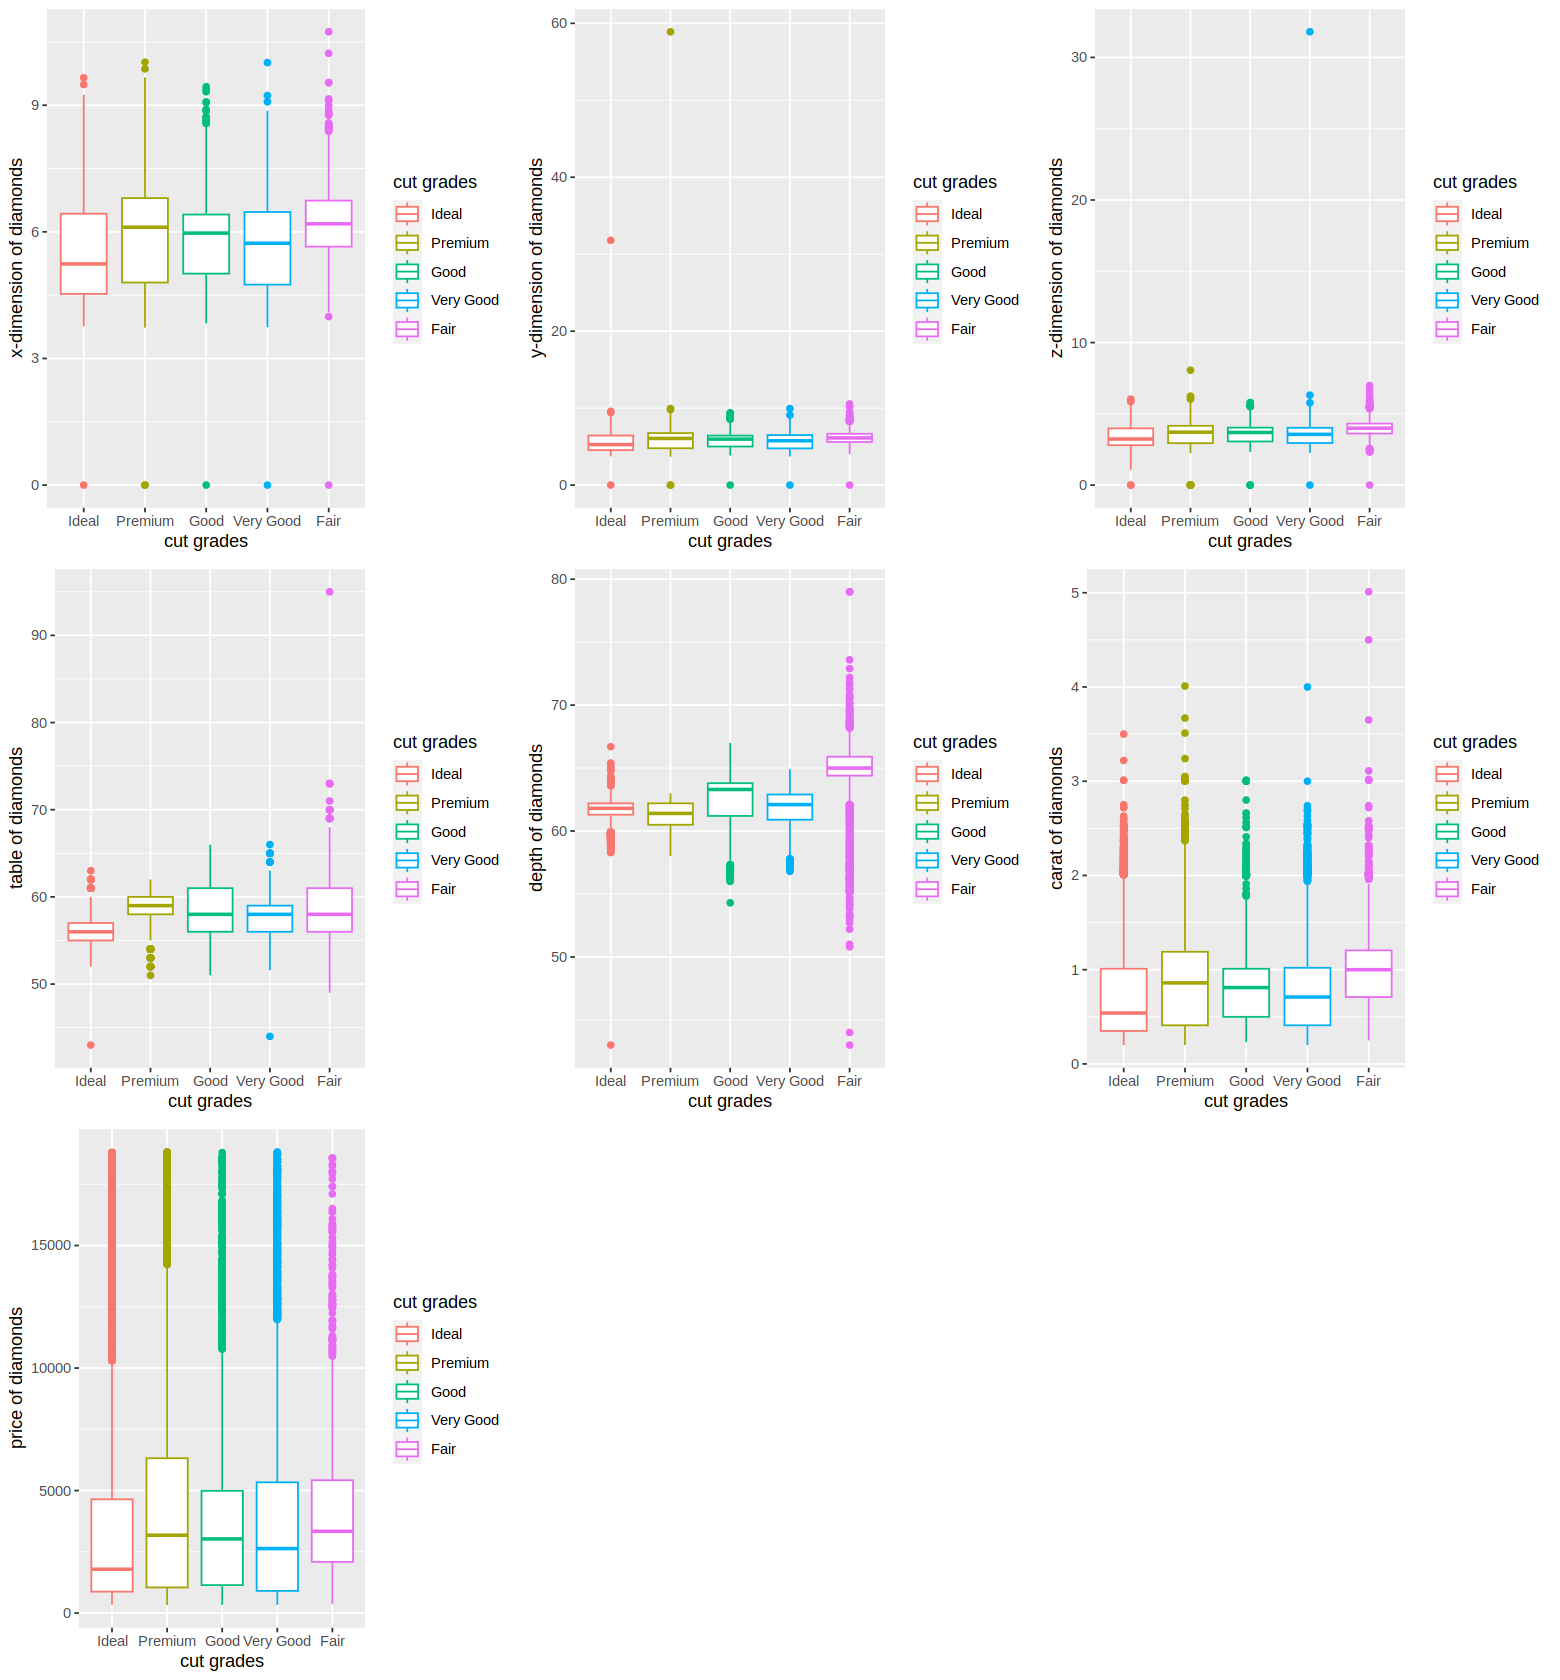

In [4]:
options(repr.plot.width = 13, repr.plot.height = 14)
x_cut_graph <- diamond_training |>
ggplot(aes(x = cut, y = x, color = cut)) +
geom_boxplot() +
labs(x ="cut grades", y = "x-dimension of diamonds", color = "cut grades")

y_cut_graph <- diamond_training |>
ggplot(aes(x = cut, y = y, color = cut)) +
geom_boxplot() +
labs(x ="cut grades", y = "y-dimension of diamonds", color = "cut grades")

z_cut_graph <- diamond_training |>
ggplot(aes(x = cut, y = z, color = cut)) +
geom_boxplot() +
labs(x ="cut grades", y = "z-dimension of diamonds", color = "cut grades")

table_cut_graph <- diamond_training |>
ggplot(aes(x = cut, y = table, color = cut)) +
geom_boxplot() +
labs(x ="cut grades", y = "table of diamonds", color = "cut grades")

depth_cut_graph <- diamond_training |>
ggplot(aes(x = cut, y = depth, color = cut)) +
geom_boxplot() +
labs(x ="cut grades", y = "depth of diamonds", color = "cut grades")

carat_cut_graph <- diamond_training |>
ggplot(aes(x = cut, y = carat, color = cut)) +
geom_boxplot() +
labs(x ="cut grades", y = "carat of diamonds", color = "cut grades")

price_cut_graph <- diamond_training |>
ggplot(aes(x = cut, y = price, color = cut)) +
geom_boxplot() +
labs(x ="cut grades", y = "price of diamonds", color = "cut grades")

plot_grid(x_cut_graph, y_cut_graph, z_cut_graph, table_cut_graph, depth_cut_graph, carat_cut_graph, price_cut_graph, align = "h", ncol = 3)

The more separate the boxes are, the more accurate prediction it will make. Based on the graph, none of them are strongly associated with the cut grades. We can maximize the prediction accuracy by choosing the relatively associated factors like: depth and table.

### 3. Methods

In reality, the cut grades are classified based on how well the diamond can reflect light. x, y, z, depth, and table are symmetry factors and should be considered as predictors. However, based on the graphs we have plotted, the associations are weak. Therefore, we only choose depth and table as predictors. If the accuracy is not desirable, we will add the x, y, and z in, and compare the accuracy. We will visualize the results by plotting the accuracy graphs. We hypothesize the addition of x, y, and z columns will not affect the accuracy too much because the boxes of each type looks almost identical. 

In [ ]:
set.seed(2023)

diamond_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

diamond_recipe <- recipe(cut ~ depth, table, data = diamond_training) |>
step_scale(all_predictors()) |>
step_center(all_predictors())


k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))
diamond_vfold_5 <- vfold_cv(diamond_training, v = 5, strata = cut)

diamond_fit_5 <- workflow() |>
  add_recipe(diamond_recipe) |>
  add_model(diamond_spec) |>
  tune_grid(resamples = diamond_vfold_5, grid = k_vals)

diamond_vfold_5_metrics <- diamond_fit_5 |>
collect_metrics()

In [ ]:
set.seed(2023)
diamond_vfold_10 <- vfold_cv(diamond_training, v = 10, strata = cut)

diamond_fit_10 <- workflow() |>
  add_recipe(cancer_recipe) |>
  add_model(knn_spec) |>
  fit_resamples(resamples = diamond_vfold_10)

diamond_vfold_10_metrics <- diamond_fit_10 |>
collect_metrics()

In [ ]:
diamond_vfold_5_metrics
diamond_vfold_10_metrics

### 4 Expected outcomes and significance

The expected outcome is that the cut grade prediction accuracy will be low, as the associations are not strong. In terms of impacts, if the accuracy is desirable, the model can speed up the process of grading the diamonds.

**Future questions** 
1. What factors do affect the cut of the diamond?
2. How can we improve the prediction accuracy? 

### References

1. Why Is A Diamond’s Cut Important?. (n.d.). BRILLIANT EARTH. https://www.brilliantearth.com/en-ca/diamond/buying-guide/cut/